In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelBinarizer

In [3]:
'''
read the data from the files
check if you nead to update path
'''
# EEG_features_3_sec = pd.read_csv("output_b/df_EEG_b_features_Tob_-3_toTob_0.csv")
# EEG_features_2_sec = pd.read_csv("output_b/df_EEG_b_features_Tob_-60_toTob_0.csv")
# EEG_features_60_sec = pd.read_csv("output_b/df_EEG_b_features_Tob_-2_toTob_0.csv")
EEG_features_3_until_2_sec = pd.read_csv("output_b/df_EEG_b_features_Tob_-3_toTob_-2.csv")
paymentMethod = pd.read_csv("df_painOfPayment_method.csv")
painOfPayment_score = pd.read_csv("df_painOfPayment_score.csv")

In [4]:
def merge_all(EEG_features):
    df_merged = pd.merge(EEG_features, paymentMethod, on="subject", how="inner")
    df_merged = pd.merge(df_merged, painOfPayment_score, on="subject", how="inner")

    return df_merged

In [5]:
'''
initialize variables
'''
waves = ['delta', 'theta', 'alpha', 'beta', 'gamma']
# df_data_3_sec = merge_all(EEG_features_3_sec)
# df_data_2_sec = merge_all(EEG_features_2_sec)
# df_data_60_sec = merge_all(EEG_features_60_sec)
df_data_3_until_2_sec = merge_all(EEG_features_3_until_2_sec)

In [6]:
def get_RandomForest_hyperparameters(X_train,y_train, classification = True):
    
    # Number of trees in Random Forest
    # n_estimators = [50, 100, 200, 300]
    n_estimators = [10, 25, 50, 100, 150, 200]
    
    # Number of features to consider at every split
    max_features = ['sqrt', 'log2', None]
    
    # Maximum number of levels in tree
    max_depth = [3, 5, 7, 10, 15, None]
    
    # min_samples_split
    min_split = [2,3,4,5]
      
    param_grid = {'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth':max_depth,
                  'min_samples_split': min_split
                 }
    
    if classification:
        rf_base = RandomForestClassifier(random_state = 42)
    else:
        rf_base = RandomForestRegressor(random_state = 42)
    
    '''
    Create the grid search Random Forest:
    GridSearchCV
        GridSearch: taking all of paramters combination from the grid parameters to find the best hyper parameters
        CV: using cross validation 
    cv = 4 (4-fold cross validation) --> validation_set = 20% from all data (0.8 X 0.25 = 0.2)
    cv = 5 (5-fold cross validation)
    cv = LeaveOneOut()
    ''' 
    # note: if regression and cv = LeaveOneOut() --> use scoring = 'neg_mean_absolute_error'
    rf_search = GridSearchCV(estimator = rf_base, param_grid = param_grid, 
                               cv = 5, verbose = 2, n_jobs = -1)
    
    # Fit the random search model
    rf_search.fit(X_train, y_train)
    
    return rf_search

In [7]:
def get_SVC_hyperparameters(X_train, y_train):
    
    # 
    C = [0.1,1, 10, 100, 1000]
    
    # 
    gamma = [1,0.1,0.01,0.001,0.0001]
       
    param_grid = {'C': C, 'gamma': gamma}
    
    SVC_base = SVC(random_state = 42)
    
    '''
    Create the grid search SVC:
    GridSearchCV
        GridSearch: taking all of paramters combination from the grid parameters to find the best hyper parameters
        CV: using cross validation 
    cv = 4 (4-fold cross validation) --> validation_set = 20% from all data (0.8 X 0.25 = 0.2)
    cv = 5 (5-fold cross validation)
    cv = LeaveOneOut()
    ''' 
    
    SVC_search = GridSearchCV(estimator = SVC_base, param_grid = param_grid, 
                               cv = 5, verbose = 2, n_jobs = -1)
    
    # Fit the random search model
    SVC_search.fit(X_train, y_train)
    
    return SVC_search

In [8]:
'''
get model hyperParameters
'''
def get_classification_hyperParameters(X_train, y_train):
    rfc_serach = get_RandomForest_hyperparameters(X_train, y_train)
    print(rfc_serach.best_params_)

    SVC_serach = get_SVC_hyperparameters(X_train, y_train)
    print(SVC_serach.best_params_)

In [9]:
'''
get model hyperParameters
'''
def get_regression_hyperParameters(X_train, y_train):
    rfc_serach = get_RandomForest_hyperparameters(X_train, y_train, classification = False)
    print(rfc_serach.best_params_)

In [10]:
def RandomForest_classification_model(X_train, X_test, y_train, y_test, n_estimators, max_features , max_depth,  min_samples_split):
    print("################# RandomForest #################")
   
    rfc = RandomForestClassifier(n_estimators = n_estimators, max_features = max_features, max_depth = max_depth,  min_samples_split = min_samples_split, random_state = 42)
    rfc.fit(X_train, y_train)
    print_classification_matrics(rfc, X_train, X_test, y_train, y_test)
    print("################# ROC CURVE #################")
    caclculate_ROC(rfc, X_train, X_test, y_train, y_test)

In [11]:
def RandomForest_regression_model(X_train, X_test, y_train, y_test, n_estimators, max_features , max_depth,  min_samples_split):
    print("################# RandomForest #################")
    
    rfc = RandomForestRegressor(n_estimators = n_estimators, max_features = max_features, max_depth = max_depth,  min_samples_split = min_samples_split, random_state = 42)
    rfc.fit(X_train, y_train)
    print_regression_matrics(rfc, X_train, X_test, y_train, y_test)

In [12]:
def SVC_model(X_train, X_test, y_train, y_test, C = 0.1, gamma = 1):
    print("################# SVC #################")
    
    svc = SVC(C = C, gamma = gamma, random_state = 42)
    svc.fit(X_train, y_train) 
    print_classification_matrics(svc, X_train, X_test, y_train, y_test)

In [13]:
def calssification_rule_based_model(X_train, X_test, y_train, y_test):
        
    print ("################# DummyClassifier - most_frequent #################")
    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(X_train, y_train)
    print_classification_matrics(dummy_clf, X_train, X_test, y_train, y_test)
    
    # "stratified" strategy - generates predictions by randomly selecting labels according to the distribution of categories in the training data.
    print ("################# DummyClassifier - stratified #################")
    dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
    dummy_clf.fit(X_train, y_train)
    print_classification_matrics(dummy_clf, X_train, X_test, y_train, y_test)
    
    print("################# LogisticRegression #################")
    Logistic_clf = LogisticRegression(random_state=42)
    Logistic_clf.fit(X_train, y_train)
    print_classification_matrics(Logistic_clf, X_train, X_test, y_train, y_test)

In [14]:
def regression_rule_based_model(X_train, X_test, y_train, y_test):
        
    print ("################# DummyClassifier - median #################")
    dummy_clf = DummyRegressor(strategy="median")
    dummy_clf.fit(X_train, y_train)
    print_regression_matrics(dummy_clf, X_train, X_test, y_train, y_test)
    
    print ("################# DummyClassifier - mean #################")
    dummy_clf = DummyRegressor(strategy="mean")
    dummy_clf.fit(X_train, y_train)
    print_regression_matrics(dummy_clf, X_train, X_test, y_train, y_test)
    
    print("################# LinearRegression #################")
    Linear_clf = LinearRegression()
    Linear_clf.fit(X_train, y_train)
    print_regression_matrics(Linear_clf, X_train, X_test, y_train, y_test)
    
    print("################# PolynomialRegression #################")
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    Poly_clf = LinearRegression()
    Poly_clf.fit(X_train_poly, y_train)
    print_regression_matrics(Poly_clf, X_train_poly, X_test_poly, y_train, y_test)

In [15]:
def print_classification_matrics(model, X_train, X_test, y_train, y_test):
    
    print("####### train data results #######")
    print_classification_matrics_helper(model, X_train, y_train)
    
    print("####### test data results #######")
    print_classification_matrics_helper(model, X_test, y_test)

In [16]:
def print_classification_matrics_helper(model, X, y):
    
    predictions = model.predict(X)
    curr_confusion_matrix = confusion_matrix(y, predictions)
    print("confusion_matrix: ")
    print(curr_confusion_matrix)
    curr_classification_report = classification_report(y ,predictions, zero_division=0)
    print("classification_report: ")
    print(curr_classification_report)
    print("Accuracy: ", model.score(X, y) , "\n")

In [17]:
def print_regression_matrics(model, X_train, X_test, y_train, y_test):
    
    print("####### train data results #######")
    print_regression_matrics_helper(model, X_train, y_train)
    
    print("####### test data results #######")
    print_regression_matrics_helper(model, X_test, y_test)

In [18]:
def print_regression_matrics_helper(model, X, y):
    
    predictions = model.predict(X)
    print(predictions) # to delete
    
    plt.scatter(y, predictions, alpha = 0.6)
    plt.xlabel('True score', fontsize=12)
    plt.ylabel('Predicted score')
    plt.xlim(3, 29)
    plt.ylim(3, 29)
    plt.show()
    
    sns.histplot((y-predictions), bins=50, kde=True)
    plt.title("distibution of True_Score - Predicted_Score ", fontsize=14)
    plt.show()
    
    print('MAE:', metrics.mean_absolute_error(y, predictions))
    print('MSE:', metrics.mean_squared_error(y, predictions))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, predictions)))
    print("\n")

In [19]:
'''
One-vs-Rest multiclass ROC (OvR)
'''
def caclculate_ROC(model, X_train, X_test, y_train, y_test):
    
    # Get predicted probabilities for each class
    y_prob = model.predict_proba(X_test)
    
    label_binarizer = LabelBinarizer()
    y_test_binary = label_binarizer.fit_transform(y_test)
    
    num_classes = y_prob.shape[1]
    
    # Calculate ROC curve for each class
    class_names = label_binarizer.classes_
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    
    # Initialize variables to store macro-averaged TPR and AUC
    mean_tpr = 0.0
    mean_auc = 0.0
    
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_test_binary[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (class {class_name}, AUC = {roc_auc:.2f})')
        
        mean_auc += roc_auc
        mean_tpr += np.interp(fpr_grid, fpr, tpr)
        
    
    # Macro-averaged ROC curve
    # computing the metric independently for each class and then taking the average over them, hence treating all classes equally a priori
    mean_tpr /= num_classes
    mean_auc /= num_classes
    plt.plot(fpr_grid, mean_tpr, color='b', linestyle=':', label=f'Macro-Average ROC curve (AUC = {mean_auc:.2f})', lw=2, alpha=0.8)
    
    # Micro-Averaged ROC Curve
    # aggregates the contributions (counts of true positives, false positives, true negatives, and false negatives ) from all the classes
    # In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferable over macro-averaging
    fpr_micro, tpr_micro, _ = roc_curve(y_test_binary.ravel(), y_prob.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':', linewidth=2, label='Micro-Average ROC curve (AUC = %.2f)' % roc_auc_micro)

    # Plot baseline
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves for Multi-Class Classifier')
    plt.legend(loc='lower right')
    plt.show()

In [20]:
'''
get model predictions
Call predict on the estimator with the best found parameters.
'''
def get_model_1_predicrions(X_train, X_test, y_train, y_test):
    
    # baseline
    # Rule-based models
    dummy_clf = calssification_rule_based_model(X_train, X_test, y_train, y_test)
    
    # random forest 
    # using: {'max_depth': 10, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 100}
    # using2: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 25}
    rfc = RandomForest_classification_model(X_train, X_test, y_train, y_test, n_estimators = 100, max_features = None, max_depth = 10,  min_samples_split = 2)

    # SVM
    # using: {'C': 0.1, 'gamma': 1}
    svc = SVC_model(X_train, X_test, y_train, y_test)


################# DummyClassifier - most_frequent #################
####### train data results #######
confusion_matrix: 
[[ 0 18  0]
 [ 0 29  0]
 [ 0 14  0]]
classification_report: 
              precision    recall  f1-score   support

        Cash       0.00      0.00      0.00        18
 Credit Card       0.48      1.00      0.64        29
  Smartphone       0.00      0.00      0.00        14

    accuracy                           0.48        61
   macro avg       0.16      0.33      0.21        61
weighted avg       0.23      0.48      0.31        61

Accuracy:  0.47540983606557374 

####### test data results #######
confusion_matrix: 
[[0 5 0]
 [0 3 0]
 [0 8 0]]
classification_report: 
              precision    recall  f1-score   support

        Cash       0.00      0.00      0.00         5
 Credit Card       0.19      1.00      0.32         3
  Smartphone       0.00      0.00      0.00         8

    accuracy                           0.19        16
   macro avg       0.06   

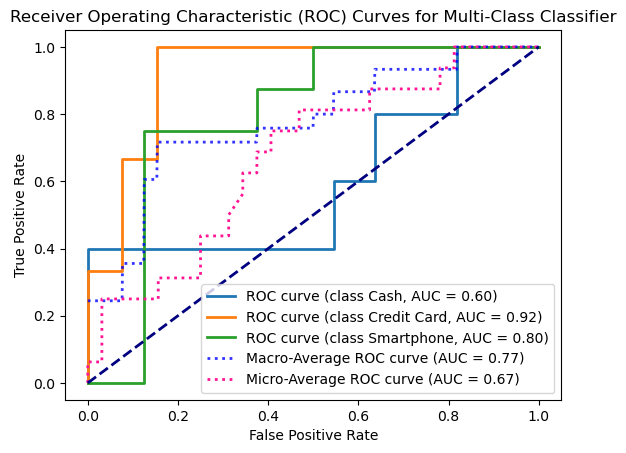

################# SVC #################
####### train data results #######
confusion_matrix: 
[[ 0 18  0]
 [ 0 29  0]
 [ 0 14  0]]
classification_report: 
              precision    recall  f1-score   support

        Cash       0.00      0.00      0.00        18
 Credit Card       0.48      1.00      0.64        29
  Smartphone       0.00      0.00      0.00        14

    accuracy                           0.48        61
   macro avg       0.16      0.33      0.21        61
weighted avg       0.23      0.48      0.31        61

Accuracy:  0.47540983606557374 

####### test data results #######
confusion_matrix: 
[[0 5 0]
 [0 3 0]
 [0 8 0]]
classification_report: 
              precision    recall  f1-score   support

        Cash       0.00      0.00      0.00         5
 Credit Card       0.19      1.00      0.32         3
  Smartphone       0.00      0.00      0.00         8

    accuracy                           0.19        16
   macro avg       0.06      0.33      0.11        16


In [21]:
'''
MAIN function to get model 1
'''
# Model 1 (first question): Tries to predict the payment method based on the EEG_features

# X = df_data_60_sec[waves]
# y = df_data_60_sec['Payment_method']
X = df_data_3_until_2_sec[waves]
y = df_data_3_until_2_sec['Payment_method']

# test size is 20% from all data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#get_classification_hyperParameters(X_train, y_train)

# random forest (3 seconds before ToB):
# cv = 4: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 200}
# cv = 5: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
# cv = LeaveOneOut(): {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}

# random forest (60 before ToB).
# with min_samples_split and cv = 5: {'max_depth': 5, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 50}

# random forest (3 until 2 seconds before ToB):
# with min_samples_split and cv = 4: {'max_depth': 5, 'max_features': None, 'min_samples_split': 3, 'n_estimators': 300}
# with min_samples_split and cv = 5: {'max_depth': 10, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 100}
# with min_samples_split and cv = LeaveOneOut(): {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 50}

# random forest (3 until 2 seconds before ToB). Try to fix overfitting
# with min_samples_split and cv = 5: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 25}

# SVC (3 seconds before ToB):
# cv = 4: {'C': 100, 'gamma': 1}
# cv = 5: {'C': 0.1, 'gamma': 1}
# cv = LeaveOneOut() : {'C': 0.1, 'gamma': 1}

# SVC (3 until 2 seconds before ToB):
# cv = 4: {'C':  0.1, 'gamma': 1}
# cv = 5: {'C': 0.1, 'gamma': 1}
# cv = LeaveOneOut() : {'C': 0.1, 'gamma': 1}

get_model_1_predicrions(X_train, X_test, y_train, y_test)

In [22]:
'''
get model predictions
Call predict on the estimator with the best found parameters.
'''
def get_model_2_predicrions(X_train, X_test, y_train, y_test):
    
    # baseline
    # Rule-based models
    dummy_clf = calssification_rule_based_model(X_train, X_test, y_train, y_test)
    
    # random forest 
    # using: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 50}
    rfc = RandomForest_classification_model(X_train, X_test, y_train, y_test, n_estimators = 50, max_features = 'sqrt', max_depth = 7,  min_samples_split = 4)

    # SVM
    # using: {'C': 0.1, 'gamma': 1}
    svc = SVC_model(X_train, X_test, y_train, y_test)


################# DummyClassifier - most_frequent #################
####### train data results #######
confusion_matrix: 
[[ 0  0 19]
 [ 0  0  7]
 [ 0  0 35]]
classification_report: 
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        19
         low       0.00      0.00      0.00         7
      medium       0.57      1.00      0.73        35

    accuracy                           0.57        61
   macro avg       0.19      0.33      0.24        61
weighted avg       0.33      0.57      0.42        61

Accuracy:  0.5737704918032787 

####### test data results #######
confusion_matrix: 
[[0 0 8]
 [0 0 3]
 [0 0 5]]
classification_report: 
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         8
         low       0.00      0.00      0.00         3
      medium       0.31      1.00      0.48         5

    accuracy                           0.31        16
   macro avg       0.10    

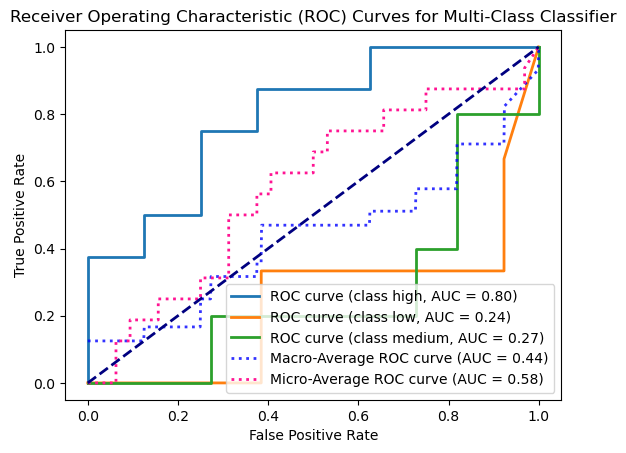

################# SVC #################
####### train data results #######
confusion_matrix: 
[[ 0  0 19]
 [ 0  0  7]
 [ 0  0 35]]
classification_report: 
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        19
         low       0.00      0.00      0.00         7
      medium       0.57      1.00      0.73        35

    accuracy                           0.57        61
   macro avg       0.19      0.33      0.24        61
weighted avg       0.33      0.57      0.42        61

Accuracy:  0.5737704918032787 

####### test data results #######
confusion_matrix: 
[[0 0 8]
 [0 0 3]
 [0 0 5]]
classification_report: 
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         8
         low       0.00      0.00      0.00         3
      medium       0.31      1.00      0.48         5

    accuracy                           0.31        16
   macro avg       0.10      0.33      0.16        16
w

In [23]:
'''
MAIN function to get model 2 - classification
'''
# Model 2 (second question) : Tries to predict the painOfPayment score based on the EEG_features

# X = df_data_60_sec[waves]
# y = df_data_60_sec['PainOfPayment_categorical_score']
X = df_data_3_until_2_sec[waves]
y = df_data_3_until_2_sec['PainOfPayment_categorical_score']

# test size is 20% from all data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# get_classification_hyperParameters(X_train, y_train)

# random forest (3 seconds before ToB):
# cv = 4: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 200}
# cv = 5: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}
# cv = LeaveOneOut(): {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 50}

# random forest (2 seconds before ToB):
# cv = 4: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 100}
# cv = 5: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}
# cv = LeaveOneOut(): {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}

# random forest (60 before ToB).
# with min_samples_split and cv = 5: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 10}

# random forest (3 until 2 seconds before ToB):
# with min_samples_split and cv = 4: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}
# with min_samples_split and cv = 5: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 50}
# with min_samples_split and cv = LeaveOneOut(): {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 100}

# random forest (3 until 2 seconds before ToB). Try to fix overfitting
# with min_samples_split and cv = 5: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 50}

# SVC (2 seconds before ToB):
# cv = 4: {'C': 0.1, 'gamma': 1}
# cv = 5: {'C': 0.1, 'gamma': 1}
# cv = LeaveOneOut() : {'C': 0.1, 'gamma': 1}

# SVC (3 until 2 seconds before ToB):
# cv = 4: {'C': 0.1, 'gamma': 1}
# cv = 5: {'C': 1000, 'gamma': 1}
# cv = LeaveOneOut() : {'C': 0.1, 'gamma': 1}

get_model_2_predicrions(X_train, X_test, y_train, y_test)

In [24]:
'''
get model predictions
Call predict on the estimator with the best found parameters.
'''
def get_model_3_predicrions(X_train, X_test, y_train, y_test):
    
    # baseline
    # Rule-based models
    dummy_clf = regression_rule_based_model(X_train, X_test, y_train, y_test)
    
    # random forest 
    # using: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}
    rfc = RandomForest_regression_model(X_train, X_test, y_train, y_test, n_estimators = 50, max_features = 'sqrt', max_depth = 15,  min_samples_split = 5)


################# DummyClassifier - median #################
####### train data results #######
[18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.
 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.
 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.
 18. 18. 18. 18. 18. 18. 18.]


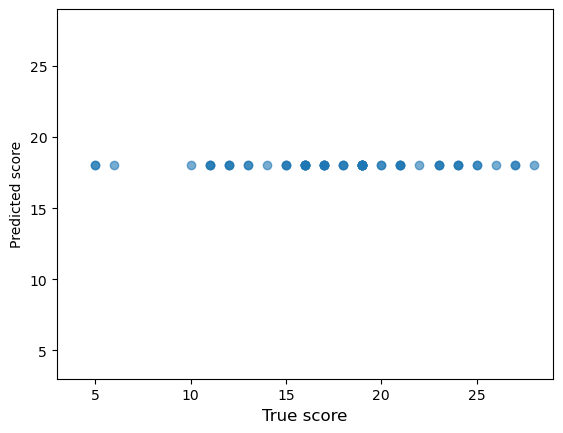

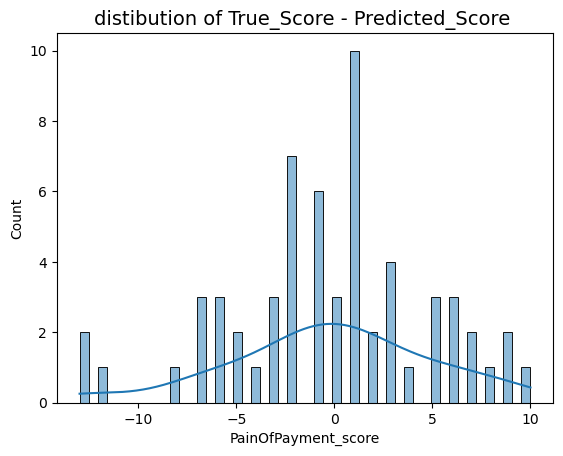

MAE: 3.9508196721311477
MSE: 26.311475409836067
RMSE: 5.129471260260268


####### test data results #######
[18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18. 18.]


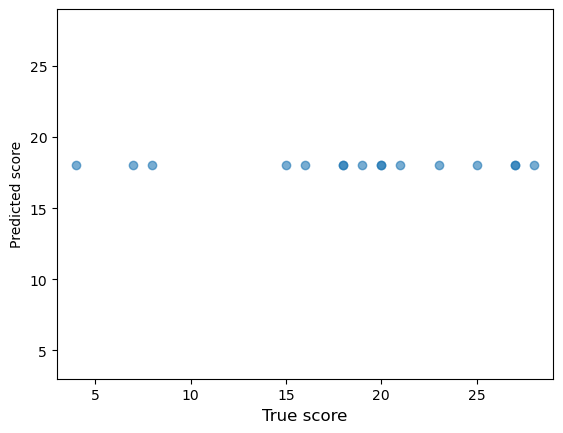

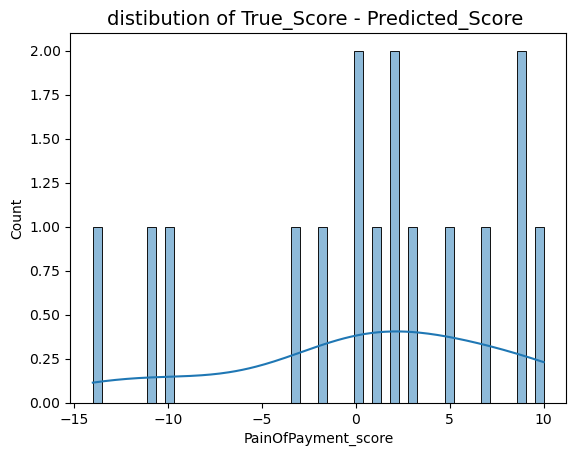

MAE: 5.5
MSE: 49.0
RMSE: 7.0


################# DummyClassifier - mean #################
####### train data results #######
[17.75409836 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836
 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836
 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836
 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836
 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836
 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836
 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836
 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836
 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836
 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836
 17.75409836]


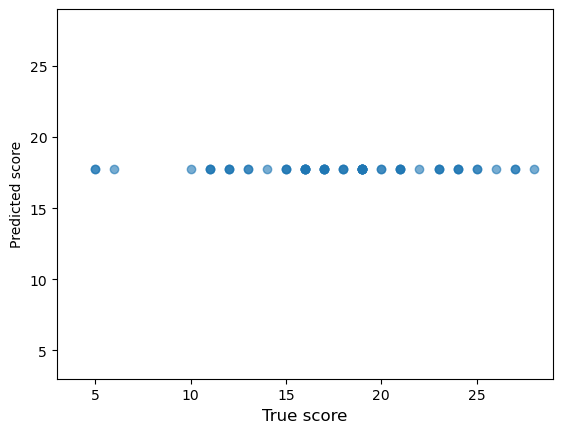

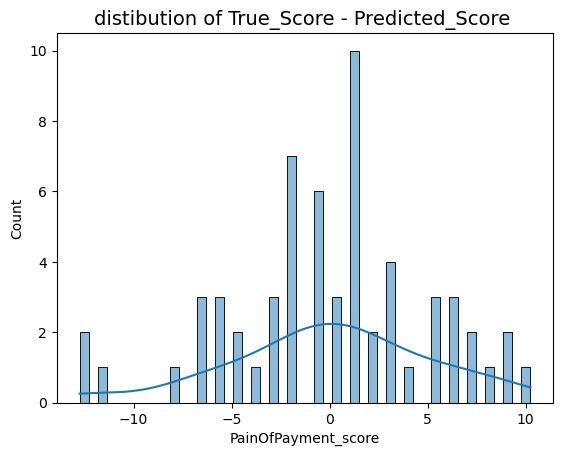

MAE: 3.962913195377587
MSE: 26.251007793603872
RMSE: 5.123573732620999


####### test data results #######
[17.75409836 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836
 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836 17.75409836
 17.75409836 17.75409836 17.75409836 17.75409836]


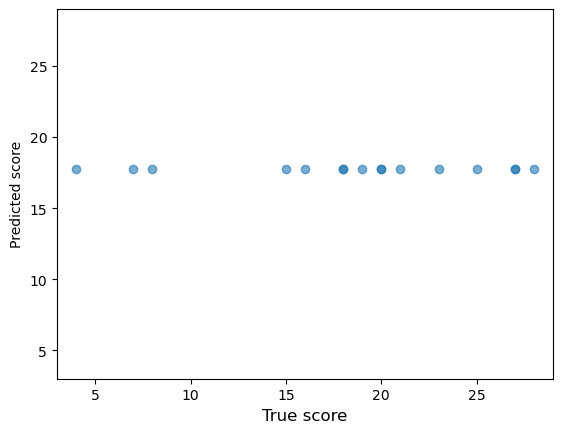

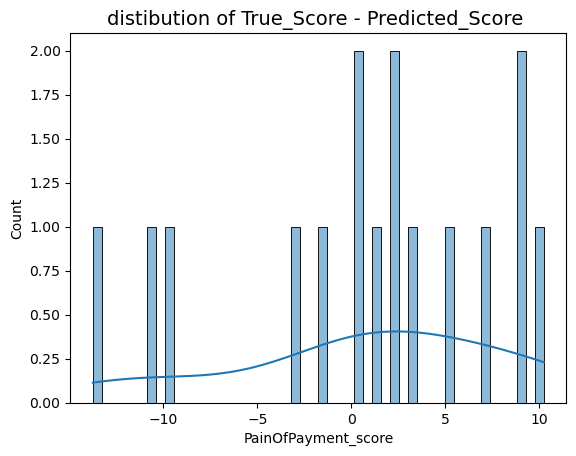

MAE: 5.592213114754098
MSE: 49.30636925557645
RMSE: 7.0218494184635185


################# LinearRegression #################
####### train data results #######
[17.61198759 16.57038304 18.05417347 19.47334787 16.44834341 18.79706924
 19.09438033 18.23449651 17.5565624  18.65357398 18.13053731 17.23027804
 17.68549427 18.74242215 19.23381284 18.29010561 17.21955945 18.16999503
 17.98117167 17.56385214 17.97277348 18.46276699 18.19932484 17.47113946
 17.33337965 16.75568057 17.58982767 18.20308085 17.42600063 17.39017241
 21.21199875 17.18617794 17.61964979 19.50405752 18.47936774 18.43667724
 17.75437992 17.17086532 17.40936348 17.77387195 17.93917154 17.21549318
 17.09454655 17.24334599 17.1767948  17.54433134 16.74447281 17.68974814
 17.10782573 16.57496298 17.27857204 17.78617594 18.27894439 17.2692903
 16.31176887 17.50899513 16.85284799 16.04292601 17.65376627 17.77532225
 17.81859519]


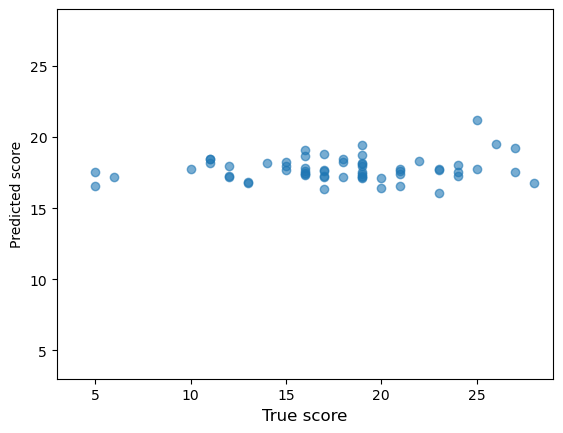

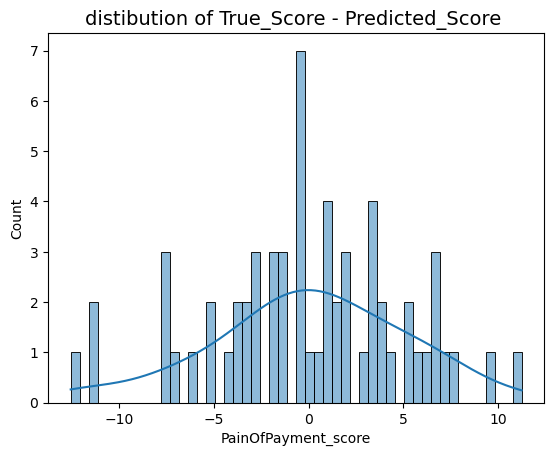

MAE: 3.9497777987206613
MSE: 25.518213731594113
RMSE: 5.051555575423684


####### test data results #######
[17.51214974 17.58504683 16.18013194 18.2037722  16.84513775 17.54457236
 17.57844291 17.48730837 18.44123215 19.81048443 17.64210987 17.58641671
 17.99634579 16.96816812 18.12422311 17.43790337]


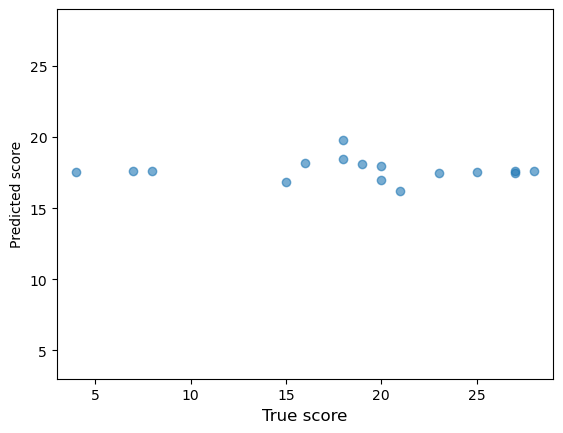

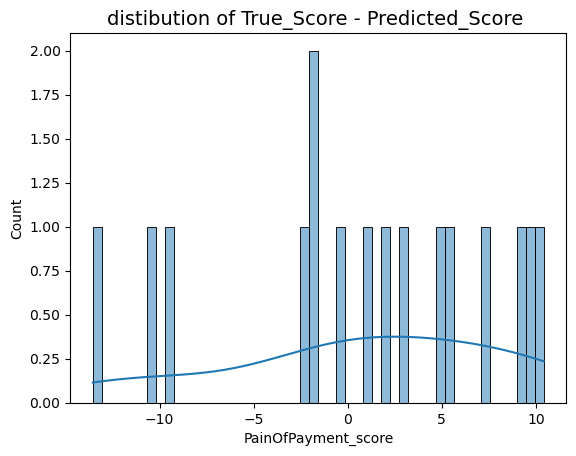

MAE: 5.824253607273995
MSE: 50.74844544910181
RMSE: 7.123794315468535


################# PolynomialRegression #################
####### train data results #######
[15.97603334 17.89918918 24.9926063  15.73128444 19.57461994 19.1011971
 15.17479167 17.91836954 16.50841867 21.0244062  18.56634705 18.52926127
 15.19197986 19.20221505 22.02687678 15.87297912 18.14337592 13.69778702
 16.94985193 23.93911134 16.31247485 14.49755112 20.59913446 17.61796821
 14.91463659 18.57275361 20.60709265 15.12393917 19.81792946 18.31831506
 25.90409326 15.81555443 14.94078498 26.28718949 15.43931193 18.71156398
 22.23895896 20.75270675 17.21453304 14.98182026 14.31501244 14.55888914
 20.11811587 15.28236606 14.74797755 24.24509827 13.69242283 15.70445943
 14.86036806 15.88200693 16.49378873 20.37172704 13.61778328 17.41678806
 19.81361893 14.48323497 15.52873339 19.65924402 13.30734025 18.7947945
 15.4172163 ]


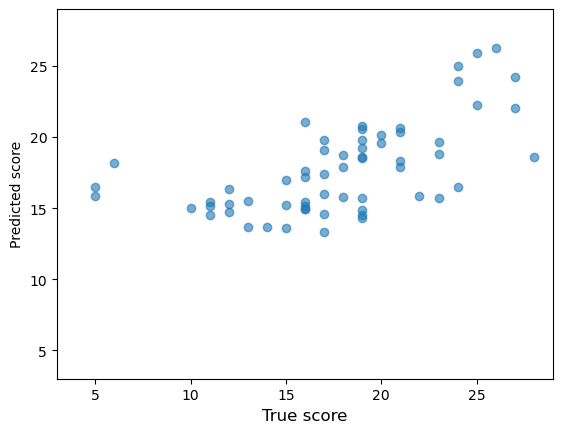

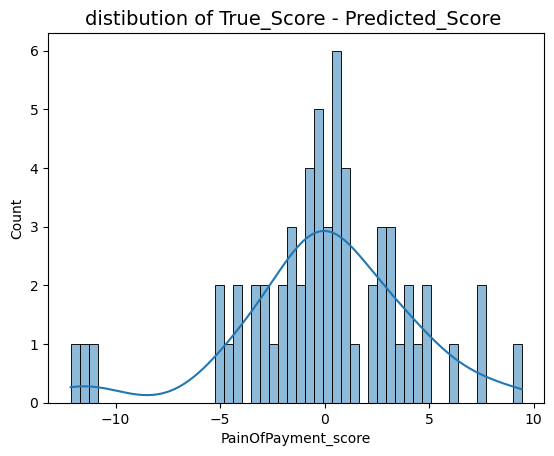

MAE: 2.880534315353672
MSE: 16.29422741935835
RMSE: 4.036610882827121


####### test data results #######
[16.16242662 27.63546942 20.31421183 26.37296501 19.39523589 14.57733057
 20.15528468 27.92173159 20.1549856  15.50952045 17.99968353 13.95542586
 21.0535198  12.81847326 19.98844066 16.35591342]


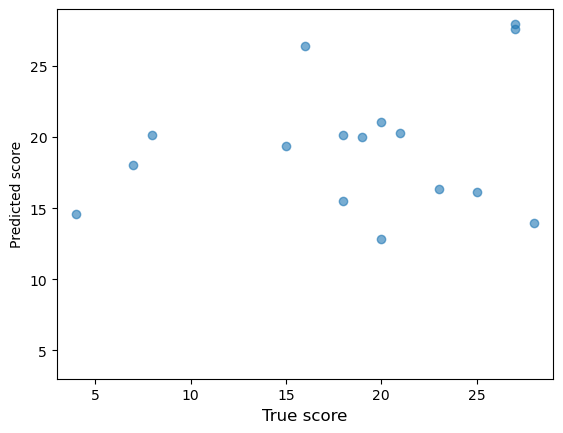

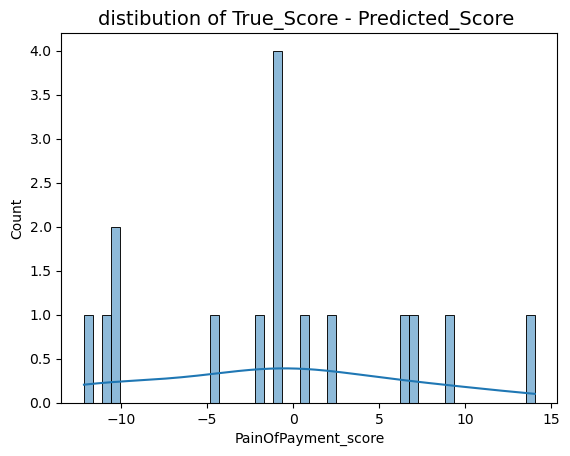

MAE: 5.883667206901357
MSE: 55.829279506135386
RMSE: 7.471899323875784


################# RandomForest #################
####### train data results #######
[18.15976263 19.3516039  21.48288095 19.52440476 18.60969913 19.0795873
 18.84169048 18.58628571 12.16709524 16.45046825 17.80824603 17.4045
 16.29580952 18.57496825 21.81135714 19.8654127  12.14030952 15.12688889
 17.06637302 20.41953968 13.36083333 14.40735714 19.80811905 17.69246825
 15.37075974 21.41392063 20.6257619  14.26080952 20.33255628 20.17611111
 22.86885714 17.01946609 16.04696609 22.21533333 14.37957937 18.57812698
 22.68204762 18.96216667 16.33785714 14.33230736 17.98646032 16.64731818
 18.57733333 14.96321429 14.64435498 23.37931818 14.3537381  19.80618254
 16.92278355 10.76631746 19.35371429 20.06175397 13.65312698 16.25707143
 18.79192063 17.66048485 14.48688095 19.65423016 17.18796825 20.68703968
 16.76839683]


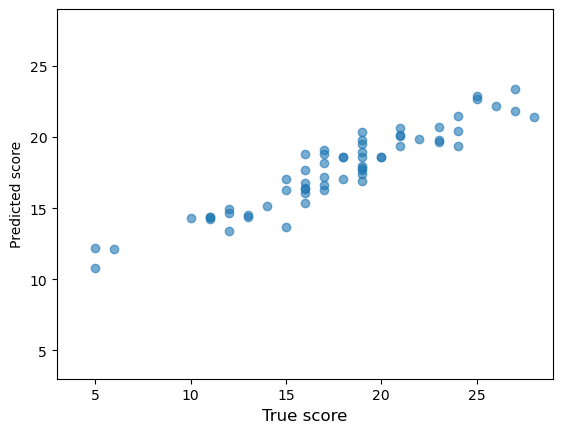

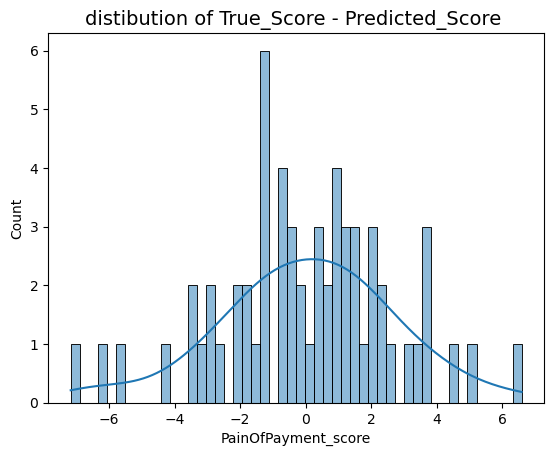

MAE: 2.075885210417998
MSE: 7.0653295420691045
RMSE: 2.658068761727037


####### test data results #######
[16.40048485 21.05916667 18.63990476 17.53292063 16.48418254 16.46372294
 19.28851587 21.69780952 19.18437302 21.70490476 18.0329531  19.01542929
 21.1228254  18.96785714 15.22483333 18.96202453]


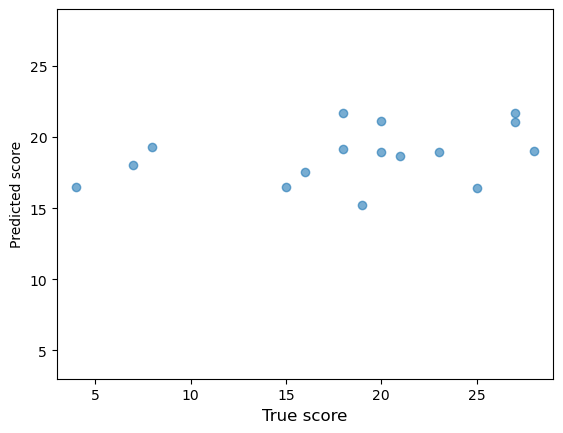

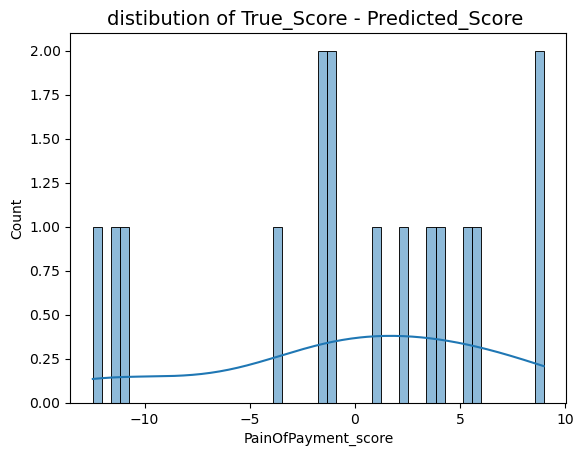

MAE: 5.24043051046176
MSE: 42.54480420730063
RMSE: 6.522637825857007




In [25]:
'''
MAIN function to get model 3 - regression
'''
# Model 3 (second question) : Tries to predict the painOfPayment score based on the EEG_features

# X = df_data_60_sec[waves]
# y = df_data_60_sec['PainOfPayment_score']
X = df_data_3_until_2_sec[waves]
y = df_data_3_until_2_sec['PainOfPayment_score']

# test size is 20% from all data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# get_regression_hyperParameters(X_train, y_train)

# random forest (3 seconds before ToB):
# with min_samples_split and cv = 4: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
# with min_samples_split and cv = 5: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 50}
# with min_samples_split and cv = LeaveOneOut(): 

# random forest (2 seconds before ToB):
# with min_samples_split and cv = 4: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
# with min_samples_split and cv = 5: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}
# with min_samples_split and cv = LeaveOneOut(): {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 50}

# random forest (60 before ToB).
# with min_samples_split and cv = 5: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}

# random forest (3 until 2 seconds before ToB):
# with min_samples_split and cv = 4: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}
# with min_samples_split and cv = 5: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}
# with min_samples_split and cv = LeaveOneOut(): {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}

# random forest (3 until 2 seconds before ToB). Try to fix overfitting:
# with min_samples_split and cv = 5: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}

get_model_3_predicrions(X_train, X_test, y_train, y_test)